   # ENRON. IDENTIFYING FRAUD.

This assignment takes a closer look on the Enron fraud case revealed in the end of 2001.

## Background. 

In its best years Enron was defined by many as innovative, ahead of its time, daring and revolutionary.

The company was formed in 1985 following a merger between Houston Natural Gas Co. and Omaha-based InterNorth Inc. As the chief executive officer (CEO) of Houston Natural Gas, Kenneth Lay became Enron's CEO and chairman, and quickly rebranded Enron into an energy trader and supplier. Enron took great advantage of the deregulation of the energy markets which allowed companies to place bets on future prices.

What allowed Enron to flourish was the dot-com bubble at the end of the 90s when the bubble was in full swing, and the Nasdaq hit 5,000. Revolutionary internet stocks were being overvalued and regulators simply accepted spiking share prices as the new normal.

Read more: Enron Scandal: 
The Fall of a Wall Street Darling | Investopedia http://www.investopedia.com/updates/enron-scandal-summary/#ixzz4M3BnGYwZ
The Rise and Fall of Enron | Journal of Accountancy http://www.journalofaccountancy.com/issues/2002/apr/theriseandfallofenron.html

In [1]:
import pprint
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pickle
import os
from time import time
import re
from numpy import log
from numpy import sqrt
from numpy import float64
from numpy import nan
import sys
sys.path.append("../tools/")
from feature_format import featureFormat, targetFeatureSplit
sys.path.append("../final_project/")
from tester import dump_classifier_and_data, test_classifier
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.grid_search import GridSearchCV
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn import cross_validation
from sklearn.cross_validation import KFold
from sklearn.tree import DecisionTreeClassifier

enron_data = pickle.load(open("../final_project/final_project_dataset.pkl", "r"))

## Exploration of the dataset

The studied dataset has a total of 146

In [2]:
#There are 146 entries
print 'Total amount of entries:',len(enron_data)

Total amount of entries: 146


Several observations are marked as "POI" which means that they were persons of interest during the legal investigation of the Enron fraud.

Some researches claim that the extent of fraud and speculations at Enron was driven by the management always demanding from new strategies, innovation and being the best on the market without scrutinizing the methods and means for achieving that.

A list of the 18 POI in this dataset is presented below.

In [3]:
#Inspired by: http://stackoverflow.com/questions/8023306/get-key-by-value-in-dictionary

for key in enron_data.keys():
    if enron_data[key]['poi'] == True:
        print 'POI:', key,
        print ' '

POI: HANNON KEVIN P  
POI: COLWELL WESLEY  
POI: RIEKER PAULA H  
POI: KOPPER MICHAEL J  
POI: SHELBY REX  
POI: DELAINEY DAVID W  
POI: LAY KENNETH L  
POI: BOWEN JR RAYMOND M  
POI: BELDEN TIMOTHY N  
POI: FASTOW ANDREW S  
POI: CALGER CHRISTOPHER F  
POI: RICE KENNETH D  
POI: SKILLING JEFFREY K  
POI: YEAGER F SCOTT  
POI: HIRKO JOSEPH  
POI: KOENIG MARK E  
POI: CAUSEY RICHARD A  
POI: GLISAN JR BEN F  


In [4]:
#Alternative 2

count = sum([1 for key in enron_data if enron_data[key]['poi'] == True])
print 'Number of POI:',count
print 'Number of nonPOI:',len(enron_data)-count

Number of POI: 18
Number of nonPOI: 128


In [5]:
for key in enron_data.iterkeys():
    print key
    print enron_data[key]
    print "--------------"

METTS MARK
{'salary': 365788, 'to_messages': 807, 'deferral_payments': 'NaN', 'total_payments': 1061827, 'exercised_stock_options': 'NaN', 'bonus': 600000, 'restricted_stock': 585062, 'shared_receipt_with_poi': 702, 'restricted_stock_deferred': 'NaN', 'total_stock_value': 585062, 'expenses': 94299, 'loan_advances': 'NaN', 'from_messages': 29, 'other': 1740, 'from_this_person_to_poi': 1, 'poi': False, 'director_fees': 'NaN', 'deferred_income': 'NaN', 'long_term_incentive': 'NaN', 'email_address': 'mark.metts@enron.com', 'from_poi_to_this_person': 38}
--------------
BAXTER JOHN C
{'salary': 267102, 'to_messages': 'NaN', 'deferral_payments': 1295738, 'total_payments': 5634343, 'exercised_stock_options': 6680544, 'bonus': 1200000, 'restricted_stock': 3942714, 'shared_receipt_with_poi': 'NaN', 'restricted_stock_deferred': 'NaN', 'total_stock_value': 10623258, 'expenses': 11200, 'loan_advances': 'NaN', 'from_messages': 'NaN', 'other': 2660303, 'from_this_person_to_poi': 'NaN', 'poi': False, 

For each person on the list there are up to 21 entered features.

In [6]:
print 'Number of features per entry:',len(enron_data[key])

Number of features per entry: 21


There is missing information about most of the people on the list.

Here is a quick preview of the first 5 entries.

In [7]:
df = pd.DataFrame(enron_data)

#Set up DF http://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.transpose.html
df1 = df.transpose()
df1.head(5)

,bonus,deferral_payments,deferred_income,director_fees,email_address,exercised_stock_options,expenses,from_messages,from_poi_to_this_person,from_this_person_to_poi,...,long_term_incentive,other,poi,restricted_stock,restricted_stock_deferred,salary,shared_receipt_with_poi,to_messages,total_payments,total_stock_value
ALLEN PHILLIP K,4175000,2869717,-3081055,NaN,phillip.allen@enron.com,1729541,13868,2195,47,65,...,304805,152,False,126027,-126027,201955,1407,2902,4484442,1729541
BADUM JAMES P,NaN,178980,NaN,NaN,NaN,257817,3486,NaN,NaN,NaN,...,NaN,NaN,False,NaN,NaN,NaN,NaN,NaN,182466,257817
BANNANTINE JAMES M,NaN,NaN,-5104,NaN,james.bannantine@enron.com,4046157,56301,29,39,0,...,NaN,864523,False,1757552,-560222,477,465,566,916197,5243487
BAXTER JOHN C,1200000,1295738,-1386055,NaN,NaN,6680544,11200,NaN,NaN,NaN,...,1586055,2660303,False,3942714,NaN,267102,NaN,NaN,5634343,10623258
BAY FRANKLIN R,400000,260455,-201641,NaN,frank.bay@enron.com,NaN,129142,NaN,NaN,NaN,...,NaN,69,False,145796,-82782,239671,NaN,NaN,827696,63014


The only feature without missing information is poi while the feature with missing information about most of the observations is loan advances.

In [8]:
#Are there features with many missing values? etc.

print 'Number of missing values per feature:'
df1[df1 == 'NaN'].count().sort_values(ascending = False)

Number of missing values per feature:


loan_advances                142
director_fees                129
restricted_stock_deferred    128
deferral_payments            107
deferred_income               97
long_term_incentive           80
bonus                         64
from_this_person_to_poi       60
from_poi_to_this_person       60
from_messages                 60
shared_receipt_with_poi       60
to_messages                   60
other                         53
expenses                      51
salary                        51
exercised_stock_options       44
restricted_stock              36
email_address                 35
total_payments                21
total_stock_value             20
poi                            0
dtype: int64

A logical explanation about the missing observations for loan advances, restricted stock deferred and deferral payments could be that they are more tipycal for executives and managers and non-employee directors. 
- Deffered payment is an executive perk used from executives to avoid/delay paying taxes.

- Director fees is paid to non-employee directors. 

- As stated in the  Report of investigation of Enron corporation and related entities regarding federal tax and compensation issues and policy recommendations defferal of restricted stock was available only for executives and non-employee directors who could choose to not recieve a share upon maturity of an option but instead Enron would credit the value to the participant's Phantom Stock Account that will be payable upon death or retirement due to disability. Credits for the dividends would be accrued in a separate account.


Presented below is a list of the top 30 observations with least amount of information. LOCKHART EUGENE E has only been indicated as no person of interest with all the rest of the information missing. I see no real reason for keeping this observation in the dataset.

Sources: 
http://www.bloomberg.com/news/articles/2002-03-03/the-danger-of-deferred-compensation
https://books.google.lt/books?id=yhSA2u91BFgC&pg=PA610&lpg=PA610&dq=restricted+stock+deferred+enron&source=bl&ots=Nb08uMf0vm&sig=OXZPsqrYA0ccumN2zHAZ48mwk3s&hl=en&sa=X&redir_esc=y#v=onepage&q=restricted%20stock%20deferred%20enron&f=false

In [9]:
#Entries with most missing information 
#Help from: http://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.sort_values.html

print 'Top 30 of the people with least amount of information:'
df[df == 'NaN'].count().sort_values(ascending = False).head(30)

Top 30 of the people with least amount of information:


LOCKHART EUGENE E                20
GRAMM WENDY L                    18
WROBEL BRUCE                     18
WHALEY DAVID A                   18
THE TRAVEL AGENCY IN THE PARK    18
WAKEHAM JOHN                     17
WODRASKA JOHN                    17
CLINE KENNETH W                  17
GILLIS JOHN                      17
SCRIMSHAW MATTHEW                17
SAVAGE FRANK                     17
MENDELSOHN JOHN                  16
YEAP SOON                        16
CHRISTODOULOU DIOMEDES           16
PEREIRA PAULO V. FERRAZ          16
BLAKE JR. NORMAN P               16
LOWRY CHARLES P                  16
CHAN RONNIE                      16
MEYER JEROME J                   16
GATHMANN WILLIAM D               16
WINOKUR JR. HERBERT S            16
FUGH JOHN L                      16
URQUHART JOHN A                  16
NOLES JAMES L                    15
WALTERS GARETH W                 15
BADUM JAMES P                    15
LEMAISTRE CHARLES                15
DUNCAN JOHN H               

3 of the main investigated people during the Enron fraud scandal were:
- Kenneth Lay – former CEO and Chairman of Enron.
- A former CFO of Enron. Fastow was indicted on 78 counts of securities fraud, money laundering, wire and mail fraud, as well as conspiracy to inflate Enron’s profit.
- A former CEO of Enron.

Source:
http://www.lawyershop.com/practice-areas/criminal-law/white-collar-crimes/securities-fraud/lawsuits/enron

In [10]:
#who took most money
print 'Total payments to Kenneth Lay:', enron_data['LAY KENNETH L']['total_payments'], 'USD'
print 'Total payments to Andrew Fastow:', enron_data['FASTOW ANDREW S']['total_payments'], 'USD'
print 'Total payments to Jeffrey Skilling:', enron_data['SKILLING JEFFREY K']['total_payments'], 'USD'

Total payments to Kenneth Lay: 103559793 USD
Total payments to Andrew Fastow: 2424083 USD
Total payments to Jeffrey Skilling: 8682716 USD


## Dealing with outliers


By plotting two of the features of interest: bonus and defferal payments I immediately see that there is a big outlier disturbing the results for the entire dataset. After closer look I find out that this observation is the TOTAL which means that it can be safely remooved. 

I also decided to remove LOCKHART EUGENE E since the only information about this person is that he is not a person of interest.

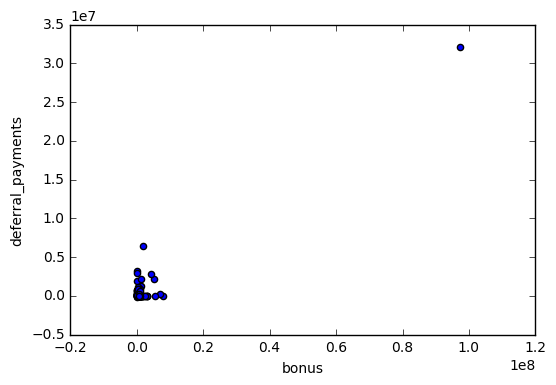

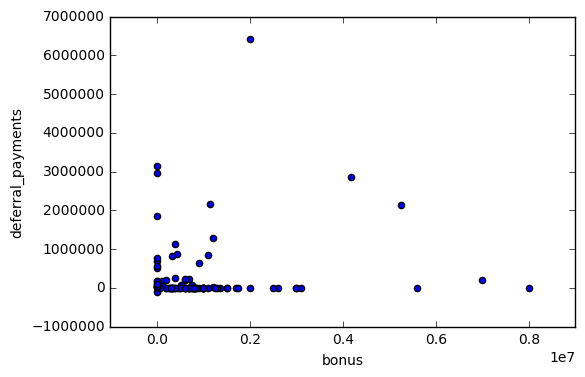

In [11]:
#!/usr/bin/python
%matplotlib inline
import matplotlib
import matplotlib.pyplot
import sys
sys.path.append("../tools/")
from feature_format import featureFormat, targetFeatureSplit

features = ["bonus", 'deferral_payments']
data = featureFormat(enron_data, features)


for point in data:
    bonus = point[0]
    deferral_payments = point[1]
    matplotlib.pyplot.scatter( bonus, deferral_payments )

matplotlib.pyplot.xlabel("bonus")
matplotlib.pyplot.ylabel("deferral_payments")
matplotlib.pyplot.show()

features = ["bonus", 'deferral_payments']
enron_data.pop( 'TOTAL', 0 ) # removing the outlier created by the entry 'Total'
enron_data.pop("LOCKHART EUGENE E", 0)
enron_data.pop("THE TRAVEL AGENCY IN THE PARK", 0)

data = featureFormat(enron_data, features)


for point in data:
    bonus = point[0]
    deferral_payments = point[1]
    matplotlib.pyplot.scatter( bonus, deferral_payments )

matplotlib.pyplot.xlabel("bonus")
matplotlib.pyplot.ylabel("deferral_payments")
matplotlib.pyplot.show()


After plotting exercised stock options and restricted stock I noticed that the observations for BHATNAGAR SANJAY and BELFER ROBERT seemed to not match the information from the Summary Schedule of all debtors combined.

I made some manual adjustments for those two people so that they will match the provided Summary Schedule.

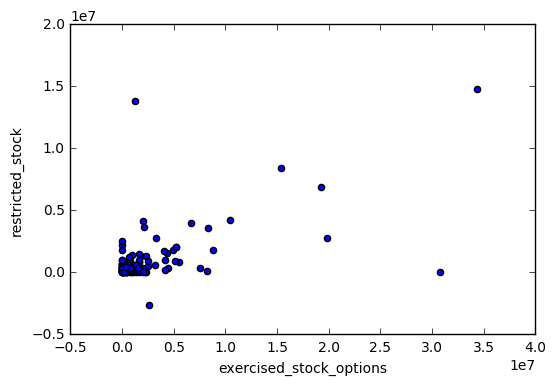

In [12]:
features = ["exercised_stock_options", "restricted_stock"]

# removing the outlier created by the entry 'Total' and Bhatnagar Sanjay since the information was incorrect according
#to other cources


data = featureFormat(enron_data, features)


for point in data:
    exercised_stock_options = point[0]
    restricted_stock = point[1]
    matplotlib.pyplot.scatter( exercised_stock_options, restricted_stock )

matplotlib.pyplot.xlabel("exercised_stock_options")
matplotlib.pyplot.ylabel("restricted_stock")
matplotlib.pyplot.show()

In [13]:
#Correcting the rest of the outliers
data_dict = enron_data
### 2.1 Correctwrong entries found after plotting deferral payments:
data_dict["BHATNAGAR SANJAY"]['restricted_stock_deferred'] = "-2604490"
data_dict["BHATNAGAR SANJAY"]['restricted_stock'] = "2604490"
data_dict["BHATNAGAR SANJAY"]['exercised_stock_options'] = "15456290"
data_dict["BHATNAGAR SANJAY"]['total_stock_value'] = "15456290"
data_dict["BHATNAGAR SANJAY"]['expenses'] = "137864"


data_dict["BELFER ROBERT"]['deferred_income'] = "-102500"
data_dict["BELFER ROBERT"]['deferral_payments'] = "NaN"
data_dict["BELFER ROBERT"]['expenses'] = "3285"
data_dict["BELFER ROBERT"]['director_fees'] = "102500"
data_dict["BELFER ROBERT"]['total_paymens'] = "3285"
data_dict["BELFER ROBERT"]['exercised_stock_options'] = "NaN"
data_dict["BELFER ROBERT"]['restricted_stock'] = "44093"
data_dict["BELFER ROBERT"]['restricted_stock_deferred'] = "-44093"
data_dict["BELFER ROBERT"]['total_stock_value'] = "NaN"

After cleaning up of the data there are no observations below 0.

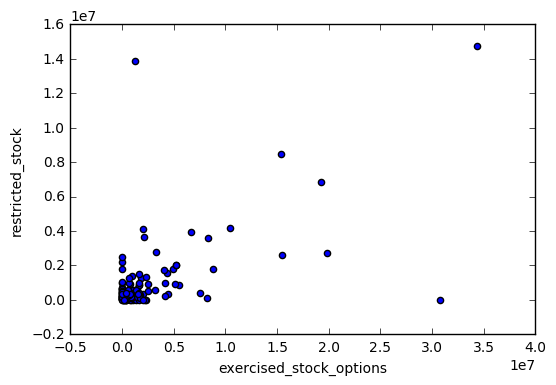

In [14]:
features = ["exercised_stock_options", "restricted_stock"]

# removing the outlier created by the entry 'Total' and Bhatnagar Sanjay since the information was incorrect according
#to other cources


data = featureFormat(enron_data, features)


for point in data:
    exercised_stock_options = point[0]
    restricted_stock = point[1]
    matplotlib.pyplot.scatter( exercised_stock_options, restricted_stock )

matplotlib.pyplot.xlabel("exercised_stock_options")
matplotlib.pyplot.ylabel("restricted_stock")
matplotlib.pyplot.show()

Next I proceed with the creation of new features.

1. I create a ratio of POI messages to total employees
2. I create an aggregate of all employee perks given to the most succesfull employees and especially executives. Accoording to most of the researching articles they together with the corporate culture of always being the best any price were the main motives for fraud.
3. Perks ratio which is the employee perks compared to total earnings.

In [15]:
###Feature creation and feature selection:
features_list = ["poi", "salary", "bonus", 'total_payments', 'loan_advances', 'total_stock_value', 'expenses', 
                 'exercised_stock_options','long_term_incentive', 'shared_receipt_with_poi', 'restricted_stock', 
                 'director_fees'] 

features_list_new = ["poi","salary", "bonus", 'total_payments', 'loan_advances', 'total_stock_value','exercised_stock_options','long_term_incentive', 'shared_receipt_with_poi', 'restricted_stock','director_fees','employee_perks', 'perks_ratio']



In [16]:
### Task 3: Create new feature(s)

# From https://github.com/DariaAlekseeva/Enron_Dataset/blob/master/Enron%20POI%20Detector%20Project%20Assignment.ipynb

#Get rid of NAN


for feature in features_list[1:]:
    for key in data_dict.keys():
        if data_dict[key][feature] == 'NaN':
            data_dict[key][feature] = 0.


for name in data_dict:

# Add ratio of POI messages to total and employee perks (https://github.com/sebasibarguen/udacity-nanodegree-machinelearning/blob/master/final_project/poi_id.py)
    try:
        total_messages = data_dict[name]['from_messages'] + data_dict[name]['to_messages']
        poi_related_messages = data_dict[name]["from_poi_to_this_person"] +\
                                data_dict[name]["from_this_person_to_poi"] +\
                                data_dict[name]["shared_receipt_with_poi"]
        poi_ratio = 1.* poi_related_messages / total_messages
        data_dict[name]['poi_ratio_messages'] = poi_ratio
    except:
        data_dict[name]['poi_ratio_messages'] = 'NaN'
    try:
        employee_perks = float(data_dict[name]["salary"])+float(data_dict[name]["bonus"])+float(data_dict[name]["long_term_incentive"])+\
                        float(data_dict[name]["total_stock_value"])
        data_dict[name]["employee_perks"] = employee_perks
    except:
        data_dict[name]['employee_perks'] = 'NaN'
    try:
        total_earnings = float(data_dict[name]["total_payments"])+float(data_dict[name]["total_stock_value"])
        data_dict[name]["perks_ratio"] = employee_perks/total_earnings
    except:
        data_dict[name]["perks_ratio"] = "NaN"


###Update the features list (https://github.com/austinjalexander/udacity_intro_ml_project/blob/master/poi_id.py)
for key in data_dict.keys():
    features_list.append("poi_ratio_messages")
    features_list.append("employee_perks")
    features_list.append("perks_ratio")


### Store to my_dataset for easy export below.
my_dataset = data_dict

After the creation of the new features I continue with the selection of the most important of them . 

It turns out that employee perks has one of the highest scores when performing the SelectKBest test.

Unfortunately poi ratio messages has rather modest results so I excluded it from the list of features I used in my further investigations.

In [17]:
from sklearn.cross_validation import StratifiedShuffleSplit
data = featureFormat(data_dict, features_list_new, sort_keys = True)
labels, features = targetFeatureSplit(data)
cv = StratifiedShuffleSplit(labels, n_iter=1000, random_state = 42)
for i_train, i_test in cv:
    features_train, features_test = [features[i] for i in i_train], [features[i] for i in i_test]
    labels_train, labels_test = [labels[i] for i in i_train], [labels[i] for i in i_test]
    for ii in i_train:
        features_train.append( features[ii] )
        labels_train.append( labels[ii] )
    for jj in i_test:
        features_test.append( features[jj] )
        labels_test.append( labels[jj] )

In [18]:
from sklearn.svm import SVC

# 1000 test and train splits
scaler = MinMaxScaler() 
skb = SelectKBest(f_classif)
pca = PCA()
svm = SVC()

#feature selection
pca_params = {"PCA__n_components":[3,4,5]}
kbest_params = {"SKB__k":[5,6,7]}
SVC_params = {'svc__kernel':('linear', 'rbf','poly'),
              'svc__C':(1,5,10),
              'svc__decision_function_shape':('ovo','over','None'),
              'svc__tol':(1e-3,1e-4,1e-5)
}
pca_params.update(kbest_params)
pca_params.update(SVC_params)
pipe= Pipeline([('scaler',scaler),("SKB", skb),("PCA", pca),("svc", svm)])
clf = GridSearchCV(pipe,pca_params, scoring='f1')
new_clf = clf.fit(features_train, labels_train)
new_pred = clf.predict(features_test)
#Result: ['salary', 'bonus', 'total_stock_value', 'exercised_stock_options', 'restricted_stock', 'employee_perks']
# you'll want to see the model selected:
clf_top = new_clf.best_estimator_
print clf_top
features_selected_bool = new_clf.best_estimator_.named_steps['SKB'].get_support()
features_selected_list = [x for x, y in zip(features_list_new[1:], features_selected_bool) if y]

print features_selected_list



C:\Users\User\Anaconda2\lib\site-packages\sklearn\metrics\classification.py:1074: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


Pipeline(steps=[('scaler', MinMaxScaler(copy=True, feature_range=(0, 1))), ('SKB', SelectKBest(k=6, score_func=<function f_classif at 0x0000000009BA24A8>)), ('PCA', PCA(copy=True, n_components=3, whiten=False)), ('svc', SVC(C=10, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovo', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False))])
['salary', 'bonus', 'total_stock_value', 'exercised_stock_options', 'restricted_stock', 'employee_perks']


Before proceeding with the testing and tuning of my classifiers of choice, I needed to choose the best features out of an existing list. In order to do that I first had to split the data in one part that was going to be used for training and another for testing. 
I mimicked the code from tester.py where the data was split with the help of StratifiedShuffleSplit.
StratifiedShuffleSplit splits the data into multitude of training and testing (validating) parts where the number of folds equals ‘n_iter’. For each of the folds StratifiedShuffleSplit chooses different points within the dataset.
The created training and testing data I used further in the selection process of the best features.
The used classifier is actually a pipeline where I used scaling with MinMaxScaler(), choosing the features with the top scores of the performed ANOVA analyses with the help of SelectKBest(). In order to reduce dimensionality I used PCA() which was followed by the classifier SVM().
For finding the optimal combination of parameters for all the components of the pipeline I used GridSearchCV where each combination was evaluated according to its F1 score. 
F1 score is the weighted average of the precision (true positives/(true positives + false positives) or the number of times the classifier has guessed correctly that somebody is a person of interest divided by all the guesses that somebody is a person of interest) and recall (true positives / (true positives + false negatives) or the number of times the classifier has guess correctly that somebody is a person of interest divided by the total number of persons of interest).
The MinMaxScaler() was used to prepare the data for the principle component analysis. It transformed the data into values ranging from 0 to 1 which was necessary in order to save the information from all the observations with 0 and to minimize the risk of PCA() giving biased results. PCA computed n number of new components (lines), based on the original data, that successfully fit all the original data points so that the distance between each of those points and the component(the line) was at its minimum. It used a similar approach as the OLS. 
Example:
Source: http://stats.stackexchange.com/questions/2691/making-sense-of-principal-component-analysis-eigenvectors-eigenvalues
The selected svm.SVC() classifer was with rbf kernel which means that the separation of the data was not following a straight line.
  
The Support vector machines focus only on the points that are the most difficult to tell apart, whereas other classifiers pay attention to all of the points.
The used C parameter controlled the tradeoff between smoother decision boundary and classifying the points correctly.
Source: http://stats.stackexchange.com/questions/23391/how-does-a-support-vector-machine-svm-work


In [19]:
features_list_best = ["poi","salary", "bonus", 'exercised_stock_options',
                     'restricted_stock','employee_perks', 'total_stock_value']
data1 = featureFormat(data_dict, features_list_best, sort_keys = True)
labels1, features1 = targetFeatureSplit(data1)
cv1 = StratifiedShuffleSplit(labels, n_iter=1000, random_state = 42)
for i_train, i_test in cv1:
    features_train1, features_test1 = [features[i] for i in i_train], [features[i] for i in i_test]
    labels_train1, labels_test1 = [labels[i] for i in i_train], [labels[i] for i in i_test]
    for ii in i_train:
        features_train1.append( features[ii] )
        labels_train1.append( labels[ii] )
    for jj in i_test:
        features_test1.append( features[jj] )
        labels_test1.append( labels[jj] )

In [20]:
NB = GaussianNB()
NB.fit(features_train1, labels_train1)
predNB = NB.predict(features_test1)

test_classifier(NB, my_dataset, features_list_best)

GaussianNB()
	Accuracy: 0.84421	Precision: 0.43522	Recall: 0.30400	F1: 0.35796	F2: 0.32351
	Total predictions: 14000	True positives:  608	False positives:  789	False negatives: 1392	True negatives: 11211



## What is parameter tuning
Each classifier (apart from simple ones like Naive Bayes), has parameters that you can select. Selecting the parameters that lead to the model with the most optimal results is parameter tuning.
I did my parameter tuning using GridSearchCV, where I specified in a 'grid' a number of different parameters which GridSearchCV fitted and returned the optimal model according to the chosen criteria F1 score.

## Model selection and tuning
In order to control the results for the best features I hardcoded the list of new features and split it the same way I did with my initial list of intuitively selected features + created ones.

I used the GausianNB() classifier as a method of controlling the goodness of my results. As mentioned earlier this is one of the simplest classifiers where there is no need of parameter tuning.


In [21]:
#classifier number 2 - Logistic regression tuning
LogisticR = LogisticRegression()
parameters = {'LogisticRegression__C':(40,50,60),
              'LogisticRegression__class_weight':('balanced',None),
              'LogisticRegression__intercept_scaling':(1,2,3),
              "LogisticRegression__max_iter": (100, 200,300),
              "LogisticRegression__tol": (1e-05,1e-06,1e-07)
              }
pca_params = {"PCA__n_components":[1,2,3,4,5]}

parameters.update(pca_params)
pipeline2 = Pipeline([('scaler',scaler),('PCA', pca),('LogisticRegression', LogisticR )])
clf1 = GridSearchCV(pipeline2, parameters, scoring='f1')
clf1.fit(features_train1, labels_train1)
pred1 = clf1.predict(features_test1)
#scaler - necessary step before PCA 
#PCA - reduces dimensionality based on 
#skb - picks best feture based on anova
#LogisticR picks a feature based on overall fit to the model


#you'll want to see the model selected:
clf_top1 = clf1.best_estimator_
print clf_top1


Pipeline(steps=[('scaler', MinMaxScaler(copy=True, feature_range=(0, 1))), ('PCA', PCA(copy=True, n_components=4, whiten=False)), ('LogisticRegression', LogisticRegression(C=50, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l2', random_state=None,
          solver='liblinear', tol=1e-05, verbose=0, warm_start=False))])


In [23]:
pca = PCA(n_components=4)
LogisticR = LogisticRegression(C=50, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=5, max_iter=100,
          multi_class='ovr', n_jobs=1, random_state=None, penalty='l2',
          solver='liblinear', tol=1e-05, verbose=0, warm_start=False )

clf_log = Pipeline([("minmax", scaler), ("PCA", pca), ("clf", LogisticR)])
clf_log.fit(features_test1, labels_test1)

test_classifier(clf_log, my_dataset, features_list_best)

Pipeline(steps=[('minmax', MinMaxScaler(copy=True, feature_range=(0, 1))), ('PCA', PCA(copy=True, n_components=4, whiten=False)), ('clf', LogisticRegression(C=50, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=5, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l2', random_state=None,
          solver='liblinear', tol=1e-05, verbose=0, warm_start=False))])
	Accuracy: 0.74600	Precision: 0.27449	Recall: 0.47350	F1: 0.34752	F2: 0.41354
	Total predictions: 14000	True positives:  947	False positives: 2503	False negatives: 1053	True negatives: 9497



Model evaluation

The model was evaluated with the help of tester.py where just as in my project the information was first imported, then split in n number of folds with the help of StratifiedShuffleSplit. In this case a 1000 number of folds were created with pseudo-randomness in the choice of different data points for each fold equal to 42.

After that the created folds were split into testing and training features and labels and fitted with the created classifier.

The goodness of fit of the classifier was then evaluated by sorting the results in 4 different categories: 
1.	True_negative - points (people) that the classifier labeled as no person of interest and they in fact were no person of interest   
2.	False_negative – points (people) that the classifier labeled as no person of interest when they in fact were a person of interest
3.	Fals_positive – points (people) that the classifier labeled as a person of interest when they in fact were not such
4.	True_positive – when the classifier successfully labeled a person of interest

After sorting each point in such manner the results are further evaluated by calculating the accuracy, precision, recall, f1 and f2.

1.	Accuracy – the sum of the true_positive and true_negative labels divided with the sum of all labels returned by the classifier
2.	Precision – the true_positive labels divided with all the poisitive labels returned by the classifier or the proportion of correctly labeled persons of interest out of all the points that the classifier counted as a person of interest
3.	Recall – the true_positive labels divided with all sum of true_positive and false_negative labels returned by the classifier i.e. the portion of correctly labeled persons of interest out of all the persons of interest that existed in the data.
4.	F1 – the weighted average of the precision and recall metrics where the best score is 1 and the worst is 0
5.	F2 – is also weighted result of precision and recall giving more weight to the recall metric. Here again the best result is 1 and worst is 0.

This meant that the results I got for my simplest classifier were below average. The main reason is the small number of persons of interest in the dataset and the multitude of missing information. The results would have been even worse if I did not create the 1000 folds of different combinations of data points with the help of StratifiedShuffleSplit.

Tuning my other two classifiers of choice

My other two classifiers of choice were the DecisionTreeClassifier and the LigisticRegression.

I repeated the same process of parameter tuning as with the feature selection.

For the Logistic regression I got:

Pipeline(steps=[('minmax', MinMaxScaler(copy=True, feature_range=(0, 1))), ('PCA', PCA(copy=True, n_components=4, whiten=False)), ('clf', LogisticRegression(C=50, class_weight='balanced', dual=False,fit_intercept=True, intercept_scaling=5, max_iter=100,multi_class='ovr', n_jobs=1, penalty='l2', random_state=None,solver='liblinear', tol=1e-05, verbose=0, warm_start=False))])




And for the Decision Tree Classifier I got:

Pipeline(steps=[('DecisionTreeClassifier', DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=None, max_features=None, max_leaf_nodes=20, min_samples_leaf=2,min_samples_split=10, min_weight_fraction_leaf=0.3,presort=False, random_state=20, splitter='best'))])

For the sake of speeding up the evaluation process I hardcoded both optimal classifiers.

At the evaluation stages I used again the test_classifier function in tester.py.

For my optimal Logistic Regression model which I obtained using Grid Search I got the following results:
Accuracy: 0.74600	Precision: 0.27449	Recall: 0.47350	F1: 0.34752	F2: 0.41354
	Total predictions: 14000	True positives:  947	False positives: 2503	False negatives: 1053	True negatives: 9497


	
Here the values for F1, F2 and especially recall were good enough for the purpose of this project but the precision was rather low which meant that my classifier was not doing well at correctly identifying someone as person of interest.

I experimented further with the parameters of my classifier until I found out that the results were mostly influenced by the number of principle components. The experimentation process is not documented. I got drastically higher results when I left only one principal component. Which meant that all the features were summed up in 1 line. Below I list the obtained results:

Pipeline(steps=[('minmax', MinMaxScaler(copy=True, feature_range=(0, 1))), ('PCA', PCA(copy=True, n_components=1, whiten=False)), ('clf', LogisticRegression(C=50, class_weight='balanced', dual=False,fit_intercept=True, intercept_scaling=5, max_iter=100,multi_class='ovr', n_jobs=1, penalty='l2', random_state=None,solver='liblinear', 
tol=1e-05, verbose=0, warm_start=False))])
Accuracy: 0.77507	Precision: 0.32846	Recall: 0.55000	F1: 0.41129	F2: 0.48462
	Total predictions: 14000	True positives: 1100	False positives: 2249	False negatives:  900	True negatives: 9751

I got above average results for my recall which meant that the chosen classifier was successfully identifying persons of interest in more than 50% present of the time. The accuracy of my classifier improved as well.

I did not choose this as my final classifier since I do not fully understand the reason behind this quite substantial change in the results and why the Grid Search has ignored this parameter combination.


In [24]:
pca = PCA(n_components=1)
LogisticR = LogisticRegression(C=50, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=5, max_iter=100,
          multi_class='ovr', n_jobs=1, random_state=None, penalty='l2',
          solver='liblinear', tol=1e-05, verbose=0, warm_start=False )

clf_log = Pipeline([("minmax", scaler), ("PCA", pca), ("clf", LogisticR)])
clf_log.fit(features_test1, labels_test1)

test_classifier(clf_log, my_dataset, features_list_best)

Pipeline(steps=[('minmax', MinMaxScaler(copy=True, feature_range=(0, 1))), ('PCA', PCA(copy=True, n_components=1, whiten=False)), ('clf', LogisticRegression(C=50, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=5, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l2', random_state=None,
          solver='liblinear', tol=1e-05, verbose=0, warm_start=False))])
	Accuracy: 0.77507	Precision: 0.32846	Recall: 0.55000	F1: 0.41129	F2: 0.48462
	Total predictions: 14000	True positives: 1100	False positives: 2249	False negatives:  900	True negatives: 9751



In [32]:
#Next is the DecisionTree
tree = DecisionTreeClassifier()
pca = PCA(n_components=5)
# classifier number 2 - Decision Tree tuning
parameters = {'DecisionTreeClassifier__min_samples_split':(10,20),
              'DecisionTreeClassifier__min_samples_leaf':(2,4),
              'DecisionTreeClassifier__max_leaf_nodes':(20,30,40,50),
              "DecisionTreeClassifier__min_weight_fraction_leaf": (0.3,0.4,0.5),
              "DecisionTreeClassifier__random_state": (20,40),
              "DecisionTreeClassifier__criterion": ('gini','entropy')
              }

pipeline1 = Pipeline([('DecisionTreeClassifier', tree )])
#scaler - necessary step before PCA 
#PCA - reduces dimensionality based on 
#skb - picks best feture based on anova
#decision tree picks a feature based on overall fit to the model
#
clf1 = GridSearchCV(pipeline1, parameters, scoring='f1')
clf1.fit(features_train1, labels_train1)
pred1 = clf1.predict(features_test1)

# you'll want to see the model selected:
clf_top1 = clf1.best_estimator_

print clf_top1

Pipeline(steps=[('DecisionTreeClassifier', DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=None,
            max_features=None, max_leaf_nodes=20, min_samples_leaf=2,
            min_samples_split=10, min_weight_fraction_leaf=0.3,
            presort=False, random_state=20, splitter='best'))])


In [30]:
clf_tree = DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=None,
            max_features=None, max_leaf_nodes=20, min_samples_leaf=2,
            min_samples_split=10, min_weight_fraction_leaf=0.3,
            presort=False, random_state=20, splitter='best')
clf = Pipeline([('DecisionTreeClassifier', clf_tree )])
clf.fit(features_train1, labels_train1)
test_classifier(clf, my_dataset, features_list_best)

Pipeline(steps=[('DecisionTreeClassifier', DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=None,
            max_features=None, max_leaf_nodes=20, min_samples_leaf=2,
            min_samples_split=10, min_weight_fraction_leaf=0.3,
            presort=False, random_state=20, splitter='best'))])
	Accuracy: 0.82500	Precision: 0.37054	Recall: 0.32200	F1: 0.34457	F2: 0.33066
	Total predictions: 14000	True positives:  644	False positives: 1094	False negatives: 1356	True negatives: 10906



For my Decision Tree Classifier I got the following results:
Accuracy: 0.82500	Precision: 0.37054	Recall: 0.32200	F1: 0.34457	F2: 0.33066
	Total predictions: 14000	True positives:  644	False positives: 1094	False negatives: 1356	True negatives: 10906


The further experimentation with the feature and model selection process I left out of this project.

Disclaimer

My feature and model selection strategies have shifted from more intuitive to more technical since the previous submission. I would continue experimenting with different data sources and searching for the perfect combination of technical knowledge and intuition.
